In [1]:
from sklearn.model_selection import train_test_split
import shutil
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.applications.efficientnet import preprocess_input


In [2]:
Base_dir = Path.cwd()                        
Dataset_dir = Base_dir / "dataset" / "processed"  
Train_dir = Dataset_dir / "train"

print("Train path:", Train_dir)
print("Exists:", Train_dir.exists())

Train path: c:\Projects\Car_Recognition\notebooks\dataset\processed\train
Exists: True


In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32


train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)


train_gen = train_datagen.flow_from_directory(
    Train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_gen = train_datagen.flow_from_directory(
    Train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)


Found 6685 images belonging to 202 classes.
Found 1564 images belonging to 202 classes.


In [25]:
print("Classes detected:", train_gen.num_classes)
print("Example mapping:", list(train_gen.class_indices.items())[:5])


Classes detected: 202
Example mapping: [('AM General Hummer SUV 2000', 0), ('Acura Integra Type R 2001', 1), ('Acura RL Sedan 2012', 2), ('Acura TL Sedan 2012', 3), ('Acura TL Type-S 2008', 4)]


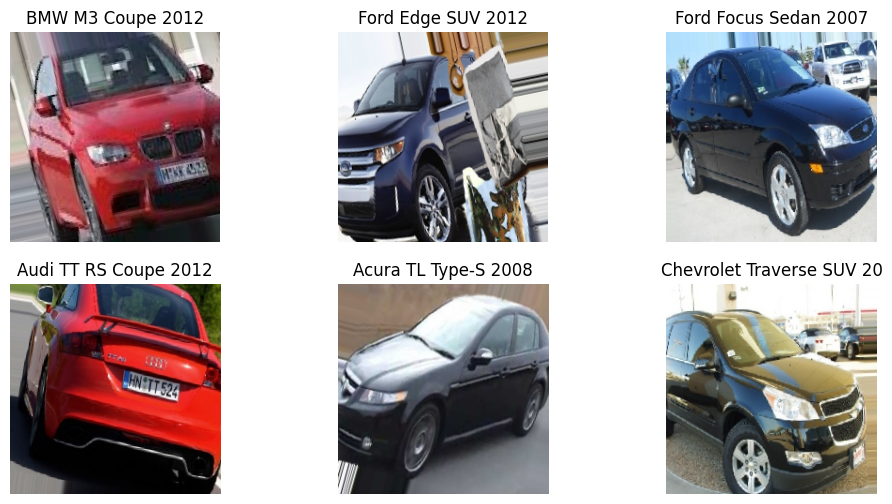

In [6]:
x_batch, y_batch = next(train_gen)
plt.figure(figsize=(12,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow((x_batch[i] - x_batch[i].min()) / (x_batch[i].max() - x_batch[i].min()))
    label_idx = y_batch[i].argmax()
    label_name = list(train_gen.class_indices.keys())[label_idx]
    plt.title(label_name[:25])
    plt.axis("off")
plt.show()

In [7]:
base_model = EfficientNetB0(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(train_gen.num_classes, activation="softmax")(x)


model = Model(inputs = base_model.input, outputs=outputs)

model.compile(
    optimizer = Adam(learning_rate=1e-3),
    loss= 'categorical_crossentropy',
    metrics = ["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,308,333 (16.43 MB)

 Trainable params: 258,762 (1010.79 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [8]:
EPOCHS = 7

history = model.fit(
    train_gen,
    validation_data = val_gen,
    epochs = EPOCHS
)

Epoch 1/7
209/209 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.1029 - loss: 4.5508 - val_accuracy: 0.2487 - val_loss: 3.7202
Epoch 2/7
209/209 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.3330 - loss: 3.3174 - val_accuracy: 0.3836 - val_loss: 3.0475
Epoch 3/7
209/209 ━━━━━━━━━━━━━━━━━━━━ 256s 1s/step - accuracy: 0.4547 - loss: 2.6934 - val_accuracy: 0.4418 - val_loss: 2.6674
Epoch 4/7
209/209 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.5399 - loss: 2.2790 - val_accuracy: 0.4808 - val_loss: 2.4066
Epoch 5/7
209/209 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.5940 - loss: 2.0057 - val_accuracy: 0.5198 - val_loss: 2.2090
Epoch 6/7
209/209 ━━━━━━━━━━━━━━━━━━━━ 278s 1s/step - accuracy: 0.6386 - loss: 1.7775 - val_accuracy: 0.5448 - val_loss: 2.0777
Epoch 7/7
209/209 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.6767 - loss: 1.6055 - val_accuracy: 0.5697 - val_loss: 1.9445


In [9]:
for layer in base_model.layers[-50:]:  
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),  
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

EPOCHS_FINE = 5
history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_FINE
)


Epoch 1/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.3551 - loss: 3.0224 - val_accuracy: 0.3977 - val_loss: 2.7643
Epoch 2/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.4283 - loss: 2.6159 - val_accuracy: 0.4009 - val_loss: 2.7380
Epoch 3/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.4956 - loss: 2.3616 - val_accuracy: 0.4584 - val_loss: 2.5043
Epoch 4/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.5454 - loss: 2.1247 - val_accuracy: 0.4898 - val_loss: 2.3327
Epoch 5/5
209/209 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.5826 - loss: 1.9281 - val_accuracy: 0.5083 - val_loss: 2.1759


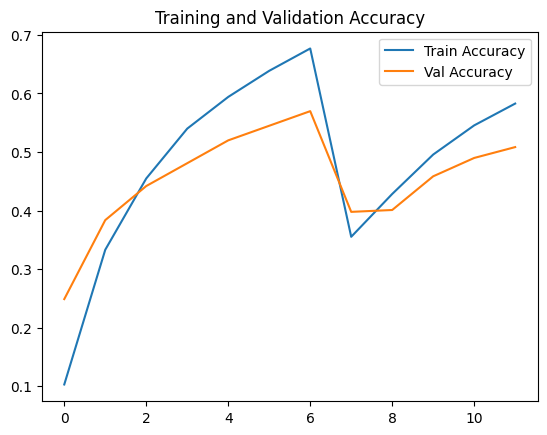

In [10]:
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()


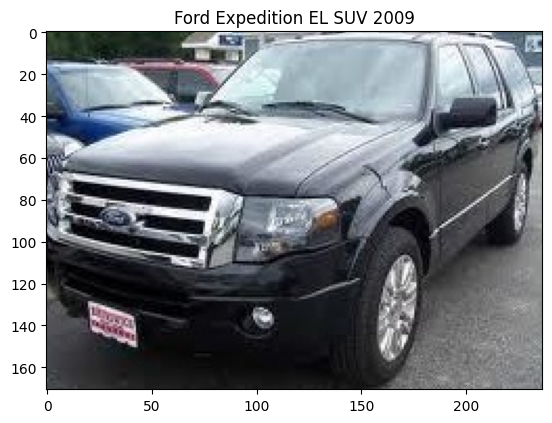

In [17]:
import cv2
import matplotlib.pyplot as plt
import random
import os

cls = random.choice(os.listdir(Train_dir))
img_name = random.choice(os.listdir(Train_dir / cls))
img = cv2.imread(str(Train_dir / cls / img_name))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(cls)
plt.show()


In [18]:
for root, dirs, files in os.walk(Train_dir):
    print(root, len(files))
    break


c:\Projects\Car_Recognition\notebooks\dataset\processed\train 0


In [19]:
print(train_gen.class_indices)


{'AM General Hummer SUV 2000': 0, 'Acura Integra Type R 2001': 1, 'Acura RL Sedan 2012': 2, 'Acura TL Sedan 2012': 3, 'Acura TL Type-S 2008': 4, 'Acura TSX Sedan 2012': 5, 'Acura ZDX Hatchback 2012': 6, 'Aston Martin V8 Vantage Convertible 2012': 7, 'Aston Martin V8 Vantage Coupe 2012': 8, 'Aston Martin Virage Convertible 2012': 9, 'Aston Martin Virage Coupe 2012': 10, 'Audi 100 Sedan 1994': 11, 'Audi 100 Wagon 1994': 12, 'Audi A5 Coupe 2012': 13, 'Audi R8 Coupe 2012': 14, 'Audi RS 4 Convertible 2008': 15, 'Audi S4 Sedan 2007': 16, 'Audi S4 Sedan 2012': 17, 'Audi S5 Convertible 2012': 18, 'Audi S5 Coupe 2012': 19, 'Audi S6 Sedan 2011': 20, 'Audi TT Hatchback 2011': 21, 'Audi TT RS Coupe 2012': 22, 'Audi TTS Coupe 2012': 23, 'Audi V8 Sedan 1994': 24, 'BMW 1 Series Convertible 2012': 25, 'BMW 1 Series Coupe 2012': 26, 'BMW 3 Series Sedan 2012': 27, 'BMW 3 Series Wagon 2012': 28, 'BMW 6 Series Convertible 2007': 29, 'BMW ActiveHybrid 5 Sedan 2012': 30, 'BMW M3 Coupe 2012': 31, 'BMW M5 Sed

In [21]:
Mod_base_dir = Path.cwd().parent
Model_path = Mod_base_dir/"models"

Model_path.mkdir(exist_ok=True)

In [28]:

Version = "V2-2"

model.save(Model_path/f"car_model_efficientnet_{Version}.keras")
model.save(Model_path/f"car_model_efficientnet_{Version}.h5")

print("Model save: ", Model_path)
 

Model save:  c:\Projects\Car_Recognition\models


In [32]:
BASE_DIR = Path.cwd().parent

MODELS_DIR = BASE_DIR / "models"
MODELS_DIR.mkdir(exist_ok=True)

class_names = list(train_gen.class_indices.keys())

class_names_path = MODELS_DIR / "class_names.txt"

print("Saving to:", class_names_path.resolve())

with open(class_names_path, "w") as f:
    for name in class_names:
        f.write(name + "\n")

print("✅ class_names.txt saved with", len(class_names), "classes")

Saving to: C:\Projects\Car_Recognition\models\class_names.txt
✅ class_names.txt saved with 202 classes
